In [1]:
from scipy import special
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def prob_dist(alpha, beta, theta):
    log_f = np.log(special.gamma(alpha + beta)) - np.log(special.gamma(alpha)) - np.log(special.gamma(beta)) \
            + (alpha - 1) * np.log(theta) + (beta - 1) * np.log(1 - theta)
    return np.exp(log_f)
    

# Plot probability distribution

/Users/junbo.park/.venv/primary/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Certainty of win-probability')

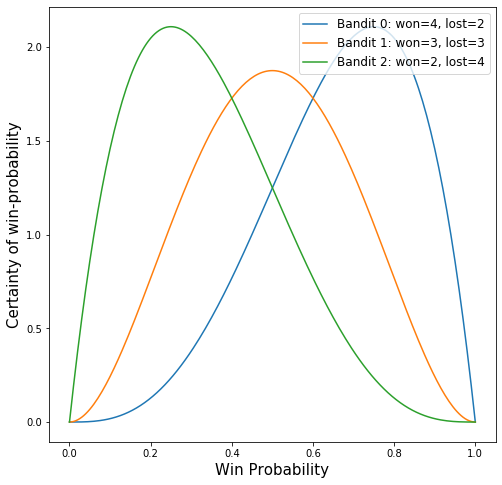

In [3]:
x = np.linspace(0, 1, 201)

plt.figure(figsize=(8,8))
for i, (alpha, beta) in enumerate ([(4, 2), (3, 3), (2, 4)]):
    plt.plot(x, prob_dist(alpha, beta, x), label="Bandit {}: won={}, lost={}".format(i, alpha, beta))
plt.legend(loc="upper right", fontsize=12)
plt.xlabel("Win Probability", fontsize=15)
plt.ylabel("Certainty of win-probability", fontsize=15)

# Compare exploration algorithm

## Greedy algorithm

In [4]:
"""
    For a given theata's (the true win-probability hidden from the "user"), we can run a simulation of 
    re-inforcement learning outcomes.
    
    In a greedy algorithm, the user estimates that the true win-probability = observed win count / number of tries.
    
"""

NUM_TRIAL = 1000
NUM_STEPS = 100
thetas = [0.9, 0.8, 0.7]

## We keep track of the average action probability defined as:
## At a given step, what is the probability of choosing the i-th bandit?
avg_action_probability_history = np.zeros((NUM_STEPS, 3))

# We run trial multiple times
for run_idx in range(NUM_TRIAL):

    # Initialize probability history and win_counts (alpha and beta)
    action_probability_history = np.zeros((NUM_STEPS, 3))
    alphas = [1, 1, 1]
    betas  = [1, 1, 1]
    
    for step in range(NUM_STEPS):

        ## In the greedy algorithm, theta estimates = wins / total_tries
        theta_estimates = np.zeros(3)
        for i in range(3):
            theta_estimates[i] = alphas[i] / (alphas[i] + betas[i])

        ## In a greedy algorithm, theta_estimates can be same for different bandits, 
        ## resulting in multiple "best" theta estimates.
        ## If there are ties, we adjust the action probability accordingly.
        action_probability = np.zeros(3)
        chosen_bandits = []
        for idx, item in enumerate(theta_estimates):
            if item == max(theta_estimates):
                chosen_bandits.append(idx)
                action_probability[idx] = 1
        
        action_probability = action_probability / np.sum(action_probability)
        action_probability_history[step, :] = action_probability

        ## We randomly choose a bandit if there are more than one optimal theta_estimate.
        chosen_bandit = chosen_bandits[np.random.choice(len(chosen_bandits)) - 1]

        # For a given bandit, we test to see if we win
        r = np.random.random()
        if r < thetas[chosen_bandit]:
            alphas[chosen_bandit] += 1
        else:
            betas[chosen_bandit] += 1 

    action_probability_history = np.array(action_probability_history)
    
    avg_action_probability_history = (run_idx * avg_action_probability_history + action_probability_history) \
        / (1 + run_idx)

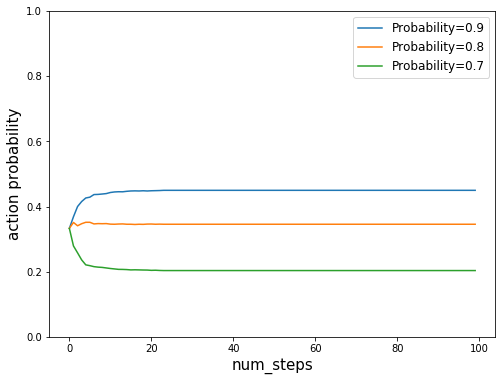

In [5]:
plt.figure(figsize=(8,6))
for i in range(3):
    plt.plot(avg_action_probability_history[:,i], label="Probability={}".format(thetas[i]))
plt.ylim((0,1))
plt.legend(fontsize=12)
plt.xlabel('num_steps', fontsize=15)
plt.ylabel('action probability', fontsize=15)
plt.show()

## Thomson sampling

In [6]:
"""
    For a given theata's (the true win-probability hidden from the "user"), we can run a simulation of 
    re-inforcement learning outcomes.
    
    If we use Thomson sampling, the user estimates the true win-probability by drawing randomly using
    the probability distribution that was presented in the presentation.
    
"""

NUM_TRIAL = 1000
NUM_STEPS = 100
thetas = [0.9, 0.8, 0.7]

avg_action_probability_history = np.zeros((NUM_STEPS, 3))

for run_idx in range(NUM_TRIAL):

    action_probability_history = np.zeros((NUM_STEPS, 3))
    alphas = [1, 1, 1]
    betas  = [1, 1, 1]
    
    for step in range(NUM_STEPS):
        theta_estimates = np.zeros(3)
        for i in range(3):
            theta_hat = np.linspace(1e-2, 1 - 1e-2, 100)
            ps = prob_dist(alphas[i], betas[i], theta_hat)
            theta_estimates[i] = np.random.choice(theta_hat, p=ps/np.sum(ps))

        ## In Thomson sampling case, there's very little chance that the theta estimates are same
        action_probability = np.zeros(3)
        chosen_bandit = np.argmax(theta_estimates)
        action_probability[chosen_bandit] = 1
        
        action_probability_history[step, :] = action_probability

        # For a given bandit, we test to see if we win
        r = np.random.random()
        if r < thetas[chosen_bandit]:
            alphas[chosen_bandit] += 1
        else:
            betas[chosen_bandit] += 1 

    action_probability_history = np.array(action_probability_history)
    
    avg_action_probability_history = (run_idx * avg_action_probability_history + action_probability_history) \
        / (1 + run_idx)

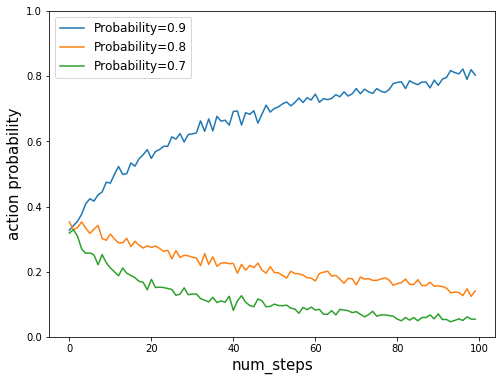

In [7]:
plt.figure(figsize=(8,6))
for i in range(3):
    plt.plot(avg_action_probability_history[:,i], label="Probability={}".format(thetas[i]))
plt.ylim((0,1))
plt.legend(fontsize=12)
plt.xlabel('num_steps', fontsize=15)
plt.ylabel('action probability', fontsize=15)
plt.show()